# MCMC: Gibbs sampling

Florent Leclercq,<br/>
Imperial Centre for Inference and Cosmology, Imperial College London,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm, gamma
from matplotlib import mlab as mlab
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import NullFormatter
from cycler import cycler
np.random.seed(123456)
%matplotlib inline
plt.rcParams.update({'lines.linewidth': 2})

## The target pdf

In [2]:
def target_joint(x,y):
    return x*x * np.exp(-x*y*y -y*y +2.*y -4.*x)
def target_marginal_x(x):
    return x*x/np.sqrt(x+1) * np.exp(-4.*x -1./(x+1.))
def target_marginal_y(y):
    return np.exp(-y*y+2.*y) / (y*y+4.)**3
def target_conditional_given_y(y):
    return gamma(a=3., scale=1./(y*y+4.))
def target_conditional_x_given_y(x,y):
    return target_conditional_given_y(y).pdf(x)
def target_conditional_given_x(x):
    return norm(loc=1./(x+1.), scale=np.sqrt(1./(2.*(x+1.))))
def target_conditional_y_given_x(y,x):
    return target_conditional_given_x(x).pdf(y)

In [3]:
# Normalization of the marginals
Nx=quad(target_marginal_x,0.0001,100.)[0]
Ny=quad(target_marginal_y,-100.,100.)[0]

In [4]:
# Marginals and conditionals peaking at one
def target_marginal_xN(x):
    return target_marginal_x(x)/target_marginal_x(x).max()
def target_marginal_yN(y):
    return target_marginal_y(y)/target_marginal_y(y).max()
def target_conditional_x_given_yN(x,y):
    return target_conditional_x_given_y(x,y)/target_conditional_x_given_y(x,y).max()
def target_conditional_y_given_xN(y,x):
    return target_conditional_y_given_x(y,x)/target_conditional_y_given_x(y,x).max()

In [5]:
xmin=0.
xmax=2.
ymin=-1.
ymax=2.5
x=np.linspace(xmin,xmax,1000)
y=np.linspace(ymin,ymax,1000)
X,Y=np.meshgrid(x,y)
Z=target_joint(X,Y)

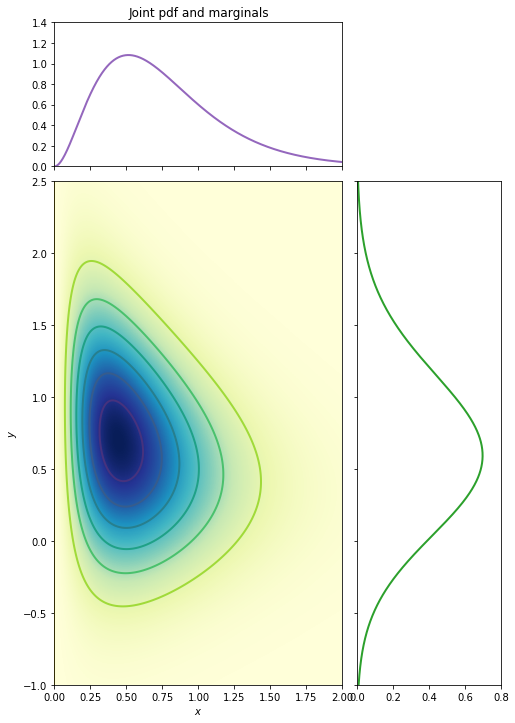

In [6]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.1
bottom_h = bottom + height + 0.1

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')

# the histograms:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')

axpdfx.set_title("Joint pdf and marginals")
plt.show()

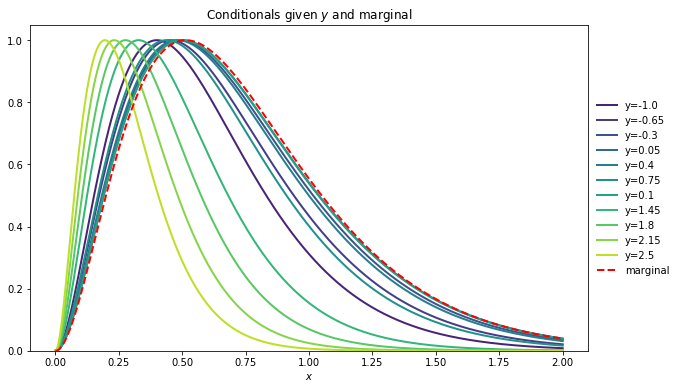

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_prop_cycle(cycler('color', [plt.cm.viridis(i) for i in np.linspace(0.1,0.9,11)]))
ax.set_ylim([0.,1.05])
ax.set_xlabel("$x$")
for this_y in np.array((-1.0,-0.65,-0.30,0.05,0.40,0.75,0.10,1.45,1.80,2.15,2.5)):
    ax.plot(x,target_conditional_x_given_yN(x,y=this_y),label='y='+str(this_y))
ax.plot(x,target_marginal_xN(x),color='red',linestyle='--',label='marginal')
ax.set_title("Conditionals given $y$ and marginal")
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

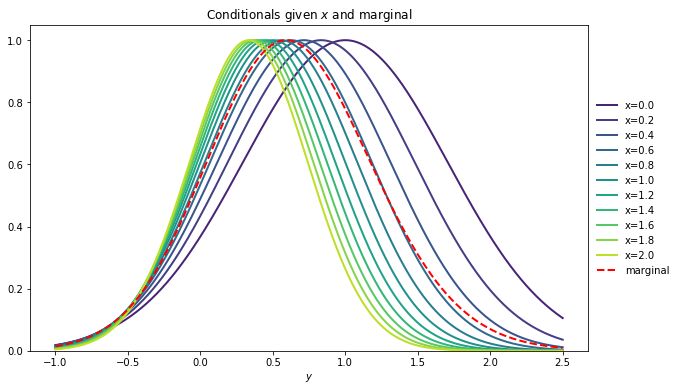

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_prop_cycle(cycler('color', [plt.cm.viridis(i) for i in np.linspace(0.1,0.9,11)]))
ax.set_ylim([0.,1.05])
ax.set_xlabel("$y$")
for this_x in np.array((0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0)):
    ax.plot(y,target_conditional_y_given_xN(y,x=this_x),label='x='+str(this_x))
ax.plot(y,target_marginal_yN(y),color='red',linestyle='--',label='marginal')
ax.set_title("Conditionals given $x$ and marginal")
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

## Gibbs sampling

In [9]:
def Gibbs_sampler(target_conditional_given_x,target_conditional_given_y,Nsamp,x_start,y_start):
    x=x_start
    y=y_start
    samples_x=[x]
    samples_y=[y]
    while len(samples_x)<Nsamp-1:
        # first update x given y
        x=target_conditional_given_y(y).rvs()
        samples_x.append(x)
        samples_y.append(y)
        # then update y given x
        y=target_conditional_given_x(x).rvs()
        samples_x.append(x)
        samples_y.append(y)
    # last step, just update x given y
    x=target_conditional_given_y(y).rvs()
    # since Gibbs sampling is rejection-free,
    # here we don't even check for acceptance
    samples_x.append(x)
    samples_y.append(y)
    return samples_x, samples_y

In [10]:
Nsamp=2000
x_start=1.8
y_start=-0.8
samples_x, samples_y=Gibbs_sampler(target_conditional_given_x,target_conditional_given_y,Nsamp,x_start,y_start)

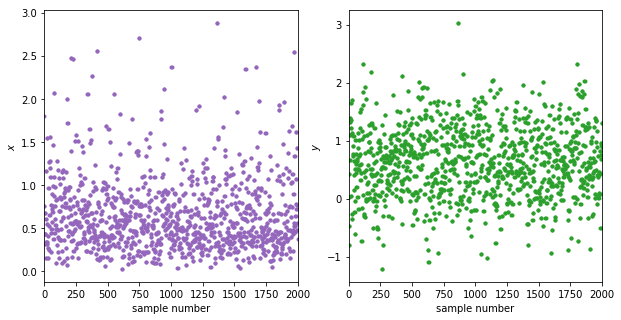

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
f.subplots_adjust(wspace=0.2)
ax1.set_xlim([0,Nsamp])
ax1.set_xlabel("sample number")
ax1.set_ylabel("$x$")
ax1.scatter(np.arange(Nsamp),samples_x,color='C4',marker='.')
ax2.set_xlim([0,Nsamp])
ax2.set_xlabel("sample number")
ax2.set_ylabel("$y$")
ax2.scatter(np.arange(Nsamp),samples_y,color='C2',marker='.')
plt.show()

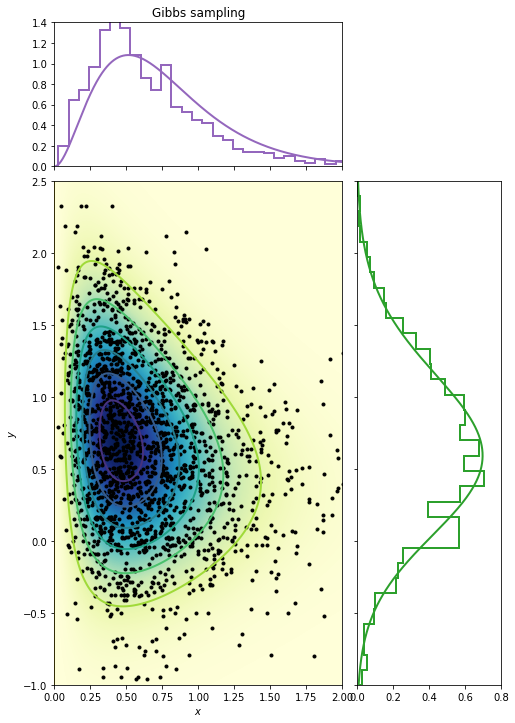

In [12]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.1
bottom_h = bottom + height + 0.1

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')
ax.scatter(samples_x,samples_y,marker='.',color='black')

# the histograms:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')
axpdfx.hist(samples_x,40,density=True,histtype='step',color='C4',linewidth=2.)

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')
axpdfy.hist(samples_y,40,density=True,histtype='step',color='C2',linewidth=2.,orientation='horizontal')

axpdfx.set_title("Gibbs sampling")
plt.show()